In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ot_mmd.mmdot import solve_apgd
from ot_mmd.utils import get_cost_G, get_t
from contour_utils import *

dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

def get_Z(xv, yv, data_P, distr_Q, C, G, max_itr, lda, case="unb"):
    nx = xv.shape[0]
    ny = yv.shape[0]
    Z = np.empty((nx, ny))
    for i in range(nx):
        for j in range(ny):
            # solve the OT problem for distributions indexed by i, j
            distr_P = torch.from_numpy(get_distr_P(data_P, (xv[i, j], yv[i, j]))).to(dtype).to(device)
            v = {1: distr_P, 2: distr_Q}
            _, obj_itr = solve_apgd(C, G, v, max_itr, lda, case=case)
            
            Z[i, j] = obj_itr[-1].item()
    return Z

def nor_min_max(a):
    return (a-a.min())/(a.max()-a.min())

dq = 2
dp = 1
intv = 0.2
tot_l = 20

khp = 10
ktype = "rbf"
lda = 1
max_itr = 1000

data_Q = get_data(dq, intv)
distr_Q = get_t(get_distr_Q(dq, data_Q), device=device)

data_Q = get_t(data_Q, device=device)
data_P = get_data(dp, intv)

x = mirrored(dp, intv)
y = mirrored(dp, intv)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

C, G = get_cost_G(get_t(data_P, device=device), data_Q, khp, ktype)

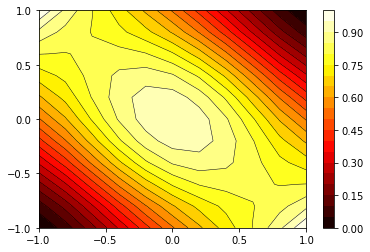

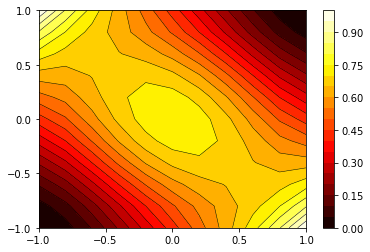

In [13]:
for case in ["unb", "bal"]:
    Z = get_Z(xv, yv, data_P, distr_Q, C, G, max_itr, lda, case=case)
    plot_fn(xv, yv, nor_min_max(Z), 0.5, f"proposed_{case}.jpg", tot_l = tot_l)